In [83]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.ops as ops
import matplotlib.pyplot as plt
import logging

In [84]:
torch.max(torch.tensor([1,2,5,6,1]))

tensor(6)

In [85]:
import os
import pandas as pd

IMAGES_DIR = '../Data/raw/images'
MASKS_DIR = '../Data/raw/masks'
METADATA_PATH = '../Data/raw/metadata.csv'
AUGMENTED_METADATA_PATH = '../Data/processed/augmentation/augmented_metadata.csv'
def get_processed_images_and_masks():
    metadata = pd.read_csv(METADATA_PATH)
    images = [os.path.join(IMAGES_DIR, img) for img in metadata['Image']]
    masks = [os.path.join(MASKS_DIR, mask) for mask in metadata['Mask']]
    return images, masks

In [86]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [87]:
# class FloodDataset(Dataset):
#     def __init__(self, images, masks, transforms=None):
#         self.images = images
#         self.masks = masks
#         self.transforms = transforms
        
#     def __getitem__(self, idx):
#         img_path = self.images[idx]
#         mask_path = self.masks[idx]
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         obj_ids = np.unique(mask)
#         obj_ids = obj_ids[1:]  # Skip background

#         masks = mask == obj_ids[:, None, None]
#         num_objs = len(obj_ids)
#         boxes = []
#         for i in range(num_objs):
#             pos = np.where(masks[i])
#             xmin = np.min(pos[1])
#             xmax = np.max(pos[1])
#             ymin = np.min(pos[0])
#             ymax = np.max(pos[0])
#             if xmin < xmax and ymin < ymax:  # Ensure positive width and height
#                 boxes.append([xmin, ymin, xmax, ymax])
#             else:
#                 logging.warning(f"Invalid box found: {xmin}, {ymin}, {xmax}, {ymax} for mask {i} in image {img_path}")

#         if not boxes:  # Handle cases where all boxes are invalid
#             boxes = torch.zeros((0, 4), dtype=torch.float32)
#             labels = torch.zeros((0,), dtype=torch.int64)
#             masks = torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
#         else:
#             boxes = torch.as_tensor(boxes, dtype=torch.float32)
#             labels = torch.ones((len(boxes),), dtype=torch.int64)
#             masks = torch.as_tensor(masks, dtype=torch.uint8)

#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["masks"] = masks
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img = self.transforms(img)
        
#         return img, target

#     def __len__(self):
#         return len(self.images)

In [88]:
class FloodDataset(Dataset):
    def _init_(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        
    def _getitem_(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        
        # Open images using PIL
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

    def _len_(self):
        return len(self.images)

In [89]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [90]:
class MaskRCNNModel:
    def __init__(self, num_classes):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.get_model_instance_segmentation(num_classes)
        self.model.to(self.device)

    def get_model_instance_segmentation(self, num_classes):
        # Load a pre-trained model for classification and return only the features
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
        backbone.out_channels = 2048

        # RPN (Region Proposal Network) anchor generator
        rpn_anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5)

        # Feature maps to be used for the ROI align operation
        roi_pooler = ops.MultiScaleRoIAlign(
            featmap_names=['0'], output_size=7, sampling_ratio=2)

        mask_roi_pooler = ops.MultiScaleRoIAlign(
            featmap_names=['0'], output_size=14, sampling_ratio=2)

        # Put the pieces together inside a MaskRCNN model
        model = MaskRCNN(backbone,
                         num_classes=num_classes,
                         rpn_anchor_generator=rpn_anchor_generator,
                         box_roi_pool=roi_pooler,
                         mask_roi_pool=mask_roi_pooler)

        return model

    def train(self, data_loader, optimizer, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            logging.info(f'Starting epoch {epoch + 1}/{num_epochs}')
            i = 0
            for images, targets in data_loader:
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                i += 1
                if i % 10 == 0:
                    logging.info(f"Epoch: {epoch + 1}, Iteration: {i}, Loss: {losses.item()}")

    def evaluate(self, data_loader):
        self.model.eval()
        with torch.no_grad():
            for images, targets in data_loader:
                images = list(image.to(self.device) for image in images)
                outputs = self.model(images)
                # Process and visualize the outputs
                for i in range(len(images)):
                    img = images[i].permute(1, 2, 0).cpu().numpy()
                    plt.imshow(img)
                    plt.show()
                    masks = outputs[i]['masks'].cpu().numpy()
                    for mask in masks:
                        plt.imshow(mask[0], alpha=0.5)
                    plt.show()

In [91]:
images, masks = get_processed_images_and_masks()

In [92]:
masks

['../Data/raw/masks\\0.png',
 '../Data/raw/masks\\1.png',
 '../Data/raw/masks\\2.png',
 '../Data/raw/masks\\3.png',
 '../Data/raw/masks\\4.png',
 '../Data/raw/masks\\5.png',
 '../Data/raw/masks\\6.png',
 '../Data/raw/masks\\7.png',
 '../Data/raw/masks\\8.png',
 '../Data/raw/masks\\9.png',
 '../Data/raw/masks\\10.png',
 '../Data/raw/masks\\11.png',
 '../Data/raw/masks\\12.png',
 '../Data/raw/masks\\13.png',
 '../Data/raw/masks\\14.png',
 '../Data/raw/masks\\15.png',
 '../Data/raw/masks\\16.png',
 '../Data/raw/masks\\17.png',
 '../Data/raw/masks\\18.png',
 '../Data/raw/masks\\19.png',
 '../Data/raw/masks\\20.png',
 '../Data/raw/masks\\21.png',
 '../Data/raw/masks\\22.png',
 '../Data/raw/masks\\23.png',
 '../Data/raw/masks\\24.png',
 '../Data/raw/masks\\25.png',
 '../Data/raw/masks\\26.png',
 '../Data/raw/masks\\27.png',
 '../Data/raw/masks\\28.png',
 '../Data/raw/masks\\29.png',
 '../Data/raw/masks\\30.png',
 '../Data/raw/masks\\31.png',
 '../Data/raw/masks\\32.png',
 '../Data/raw/masks\

In [93]:
images 

['../Data/raw/images\\0.jpg',
 '../Data/raw/images\\1.jpg',
 '../Data/raw/images\\2.jpg',
 '../Data/raw/images\\3.jpg',
 '../Data/raw/images\\4.jpg',
 '../Data/raw/images\\5.jpg',
 '../Data/raw/images\\6.jpg',
 '../Data/raw/images\\7.jpg',
 '../Data/raw/images\\8.jpg',
 '../Data/raw/images\\9.jpg',
 '../Data/raw/images\\10.jpg',
 '../Data/raw/images\\11.jpg',
 '../Data/raw/images\\12.jpg',
 '../Data/raw/images\\13.jpg',
 '../Data/raw/images\\14.jpg',
 '../Data/raw/images\\15.jpg',
 '../Data/raw/images\\16.jpg',
 '../Data/raw/images\\17.jpg',
 '../Data/raw/images\\18.jpg',
 '../Data/raw/images\\19.jpg',
 '../Data/raw/images\\20.jpg',
 '../Data/raw/images\\21.jpg',
 '../Data/raw/images\\22.jpg',
 '../Data/raw/images\\23.jpg',
 '../Data/raw/images\\24.jpg',
 '../Data/raw/images\\25.jpg',
 '../Data/raw/images\\26.jpg',
 '../Data/raw/images\\27.jpg',
 '../Data/raw/images\\28.jpg',
 '../Data/raw/images\\29.jpg',
 '../Data/raw/images\\30.jpg',
 '../Data/raw/images\\31.jpg',
 '../Data/raw/imag

In [94]:
from PIL import Image
import matplotlib.pyplot as plt

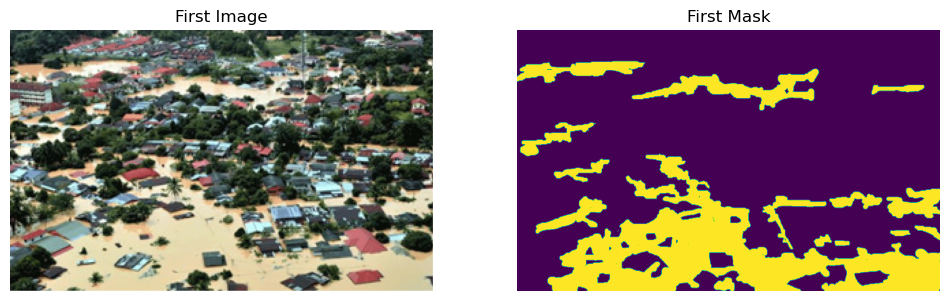

In [95]:
first_image = Image.open(images[0])
first_mask = Image.open(masks[0])

# Display the image and mask side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image
axs[0].imshow(first_image)
axs[0].set_title('First Image')
axs[0].axis('off')

# Display the first mask
axs[1].imshow(first_mask)
axs[1].set_title('First Mask')
axs[1].axis('off')

plt.show()

In [96]:
transform = transforms.Compose([transforms.ToTensor()])

In [100]:
dataset = FloodDataset(images, masks, transforms=transform)

TypeError: FloodDataset() takes no arguments

In [58]:
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [68]:
model = MaskRCNNModel(num_classes=2)

In [19]:
params = [p for p in model.model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [69]:
model.train(data_loader, optimizer, num_epochs=1)

2024-07-04 21:02:23,804 - INFO - Starting epoch 1/1


AttributeError: 'Tensor' object has no attribute 'items'

In [22]:
model.evaluate(data_loader)

2024-07-04 20:37:51,535 - WARNING - Invalid box found: 136, 165, 136, 165 for mask 25 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,539 - WARNING - Invalid box found: 470, 265, 470, 265 for mask 31 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,566 - WARNING - Invalid box found: 478, 266, 478, 266 for mask 72 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,567 - WARNING - Invalid box found: 421, 201, 421, 201 for mask 73 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,571 - WARNING - Invalid box found: 641, 130, 641, 130 for mask 78 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,572 - WARNING - Invalid box found: 349, 392, 349, 392 for mask 79 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,579 - WARNING - Invalid box found: 328, 141, 328, 141 for mask 89 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37:51,580 - WARNING - Invalid box found: 178, 214, 187, 214 for mask 90 in image ../Data/raw/images\3045.jpg
2024-07-04 20:37